# Table of Contents
* [Data Source](#data_source)
* [Project Overview](#project_overview)
* [Exploratory Data Analysis](#explore_data)
* [Data Preparation](#data_prep)
* [Building Model](#build_model)
* [Fitting Process](#fitting_process)
* [Results and Analysis](#results_analysis)
* [Conclusion](#conclusion)

# Classification of Ships
## Data Source   <a class="anchor"  id="data_source"></a>
This project is based on a Kaggle dataset that can be found here https://www.kaggle.com/datasets/arpitjain007/game-of-deep-learning-ship-datasets/data
## Project Overview  <a class="anchor"  id="project_overview"></a>
The goal of this project is to build a model capable of classifying images of oceanic vessels.  The dataset includes 6,252 training images and 2,680 prediction images. The images include ships from five categories including cargo, military, carrier, cruise, and tankers.

All of the images are fairly small and approximately 210 by 140 pixels, but there is a lot of variation in the exact size.  Some images are black and white and some are color.  All of the images can be found in the Kaggle input folders.  Correct labels for the training images have been provided in a comma-separated values (.csv) file. 

## Exploratory Data Analysis <a class="anchor"  id="explore_data"></a>
All of the image files are in the input folder.  Again, there are 6,252 training images and 2,680 prediction images.  Note, however, that this Kaggle environment is not an actual competition so there is no submission.  Additionally, there are no labels provided for the test images.  Therefore, the 2,680 prediction images had to be set aside.  In their place, the 6,252 training images were divided into three portions: one for training (70%), one for validation (20%), one for testing (10%).

The labels provided for the images used the following values:
* 1: cargo
* 2: military
* 3: carrier
* 4: cruise
* 5: tanker

The input data does not contain any missing values and has no duplicate images.  The distribution of labels is somewhat imbalanced with the Cargo class having roughly 33%, the Military and Tanker classes having roughly 19%, and the remaining two classes having 13% to 15%.  The chart in the "Distribution of labels" section below contains the details.

A few images of each ship class are displayed below.  In general, it isn't too difficult to spot the differences between some of the classes, such as, between Cargo and Military.  However, seeing the difference between Carrier and Cruise ships is a little difficult and the difference between Cargo and Tanker is very difficult.

In [1]:
# Load the core libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from tabulate import tabulate  # for pretty printing dataframes

from sklearn.model_selection import train_test_split
import PIL.Image
import re

from kaggle_datasets import KaggleDatasets

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Tensorflow version:", tf.__version__)
print("Keras version:", tf.keras.version())

2024-04-14 16:38:32.989744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 16:38:32.989848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 16:38:33.130253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Numpy version: 1.26.4
Pandas version: 2.2.1
Tensorflow version: 2.15.0
Keras version: 3.1.1


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError as e:
    print("Error: ", e)
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Error:  Please provide a TPU Name to connect to.
Number of replicas: 1


In [3]:
# Load the training data and labels.  Get information about the files in the directories.
core_path = '/kaggle/input/game-of-deep-learning-ship-datasets/'
train_path = core_path + 'train/'
image_path = core_path + 'train/images/'
df_train = pd.read_csv(train_path + 'train.csv')
df_test = pd.read_csv(core_path + 'test_ApKoW4T.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252 entries, 0 to 6251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     6252 non-null   object
 1   category  6252 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 97.8+ KB


In [4]:
# Create a function that will prefix the correct Kaggle input folder to each image ID
#   in order to have a full path and filename for the image.
def generate_file_names(id):
    return (image_path + id)

In [5]:
print("Training data frame:\n", df_train.head())
num_train_entries = len(df_train)
num_image_files = len(os.listdir(image_path))
print("Number training entries:", num_train_entries)
print("Number image files:", num_image_files)

# Get a list of all of the names of the files in the directories
train_images_dir_filenames = os.listdir(image_path)
print("A sample of the training images filenames in the directory:\n", train_images_dir_filenames[:4])

# Save off the complete path and filename for each ID as a new column
# This also establishes which images are considered for training vs which for prediction
df_train["filename"] = df_train["image"].apply(generate_file_names)

Training data frame:
          image  category
0  2823080.jpg         1
1  2870024.jpg         1
2  2662125.jpg         2
3  2900420.jpg         3
4  2804883.jpg         2
Number training entries: 6252
Number image files: 8932
A sample of the training images filenames in the directory:
 ['2213022.jpg', '2842076.jpg', '2862031.jpg', '2880224.jpg']


In [6]:
ship_cat_names = ['cargo', 'military', 'carrier', 'cruise', 'tanker']
ship_category_names = {0: 'cargo', 1: 'military', 2: 'carrier', 3: 'cruise', 4: 'tanker'}
num_classes = len(ship_category_names)
df_train['category'] = df_train['category'].apply(lambda x: x-1)
df_train['CatName'] = df_train['category'].map(ship_category_names)
df_train.head()

,image,category,filename,CatName
0,2823080.jpg,0,/kaggle/input/game-of-deep-learning-ship-datas...,cargo
1,2870024.jpg,0,/kaggle/input/game-of-deep-learning-ship-datas...,cargo
2,2662125.jpg,1,/kaggle/input/game-of-deep-learning-ship-datas...,military
3,2900420.jpg,2,/kaggle/input/game-of-deep-learning-ship-datas...,carrier
4,2804883.jpg,1,/kaggle/input/game-of-deep-learning-ship-datas...,military


## Distribution of labels

Number of empty cells: 0
Data has 0 duplicate images
All possible values for training labels: {0, 1, 2, 3, 4}
╭────────────┬─────────┬──────────────╮
│   Category │   Count │   Proportion │
├────────────┼─────────┼──────────────┤
│          0 │    2120 │        0.339 │
├────────────┼─────────┼──────────────┤
│          1 │    1167 │        0.187 │
├────────────┼─────────┼──────────────┤
│          2 │     916 │        0.147 │
├────────────┼─────────┼──────────────┤
│          3 │     832 │        0.133 │
├────────────┼─────────┼──────────────┤
│          4 │    1217 │        0.195 │
╰────────────┴─────────┴──────────────╯


Text(0.5, 0, 'Category')

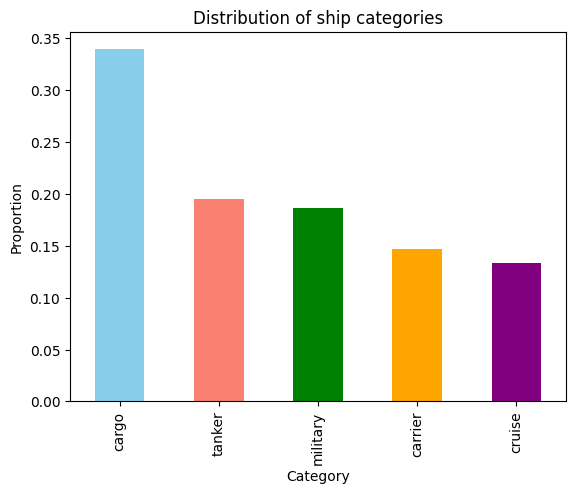

In [7]:
# Check if there are any missing values (IDs or categories)
numNaNs = df_train.isna().sum().sum()  # Count the total number of NaNs across all columns
print("Number of empty cells:", numNaNs)

# Check for duplicates
print("Data has", df_train.shape[0] - df_train['image'].nunique(), "duplicate images")

print("All possible values for training labels:", set(df_train['category']))
label_info = pd.DataFrame({'Category': range(len(set(df_train['category']))),
                           'Count': df_train['category'].value_counts().sort_index(),
                           'Proportion': round(df_train['category'].value_counts(normalize = True).sort_index(), 3)})

print(tabulate(label_info, headers='keys', tablefmt='rounded_grid', showindex=False))
df_train['CatName'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon', 'green', 'orange', 'purple'])
plt.title('Distribution of ship categories')
plt.ylabel('Proportion')
plt.xlabel('Category')

In [8]:
# Get a random sample of images and check their size and number of channels
def get_image_shape_and_mode(image_path):
    singleImage = PIL.Image.open(image_path)
    return singleImage.size, singleImage.mode

for file in df_train['filename'].sample(10).values:
    print(get_image_shape_and_mode(file))

((210, 140), 'RGB')
((210, 158), 'RGB')
((210, 111), 'RGB')
((210, 158), 'RGB')
((210, 158), 'RGB')
((210, 140), 'RGB')
((210, 132), 'RGB')
((181, 158), 'RGB')
((210, 158), 'RGB')
((210, 140), 'RGB')


## Displaying some images  <a class="anchor" id="display_images"></a>

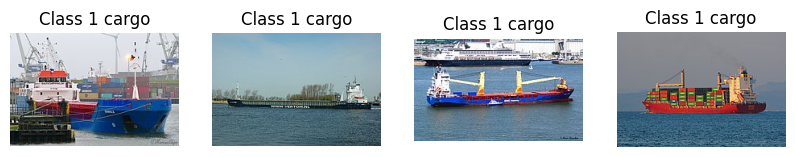

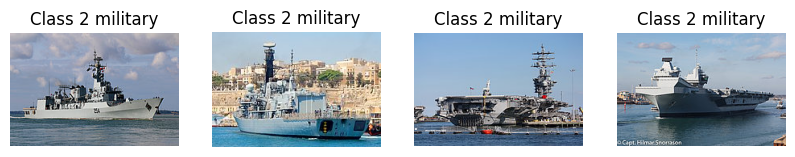

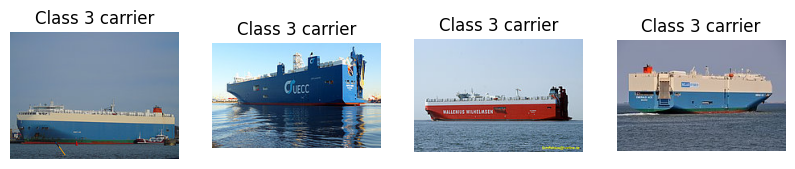

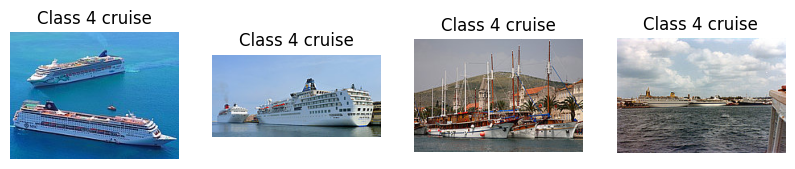

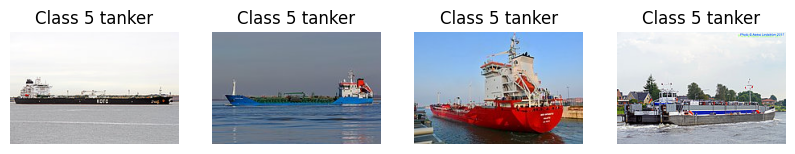

In [9]:
# Display some of the images for each type of ship
numToDisplay = 4
sample_image_files = []
for cat in range(num_classes):
    sample_image_files = df_train[df_train['category'] == cat]['filename'].sample(n = numToDisplay).values

    images = []
    for filename in sample_image_files:
        images.append(PIL.Image.open(filename))

    plt.figure(figsize=(10, 5))
    for i, image in enumerate(images):
        plt.subplot(1, 4, i+1)
        plt.imshow(image)
        plt.title("Class " + str(cat+1) + " " + ship_category_names[cat])
        plt.axis('off')
    plt.show()

# Create training, validation, and test datasets
Since this isn't an actual Kaggle competition and the true labels for the test images were not provided, the test images and test.csv won't actually be used going forward in this project.  Instead, the training images will be split into a training set, validation set, and test/prediction set.

In [10]:
# Set aside 10% of the entries in df_train to be used as a test set for predictions later on
print("df_train size at start:", len(df_train))
df_test_from_train = df_train.sample(frac = 0.10)
df_train = df_train.drop(df_test_from_train.index)
print("df_train size at end:", len(df_train))

df_train size at start: 6252
df_train size at end: 5627


### Create input image folders

In [11]:
# The following is a brute-force method to get all of the image files in categorically named sub-folders.
# This was done because the alternative using a separate array for the labels wasn't working.
import shutil
if os.path.isdir('/kaggle/working/images/') == False:
    catFiles = []
    for cat in range(num_classes):
        catFiles.append(df_train[df_train['category'] == cat]['filename'])

    outputFolders = []
    for cat in range(num_classes):
        outputFolders.append('/kaggle/working/images/' + str(cat))

    ! mkdir '/kaggle/working/images'
    ! mkdir '/kaggle/working/images/0'
    ! mkdir '/kaggle/working/images/1'
    ! mkdir '/kaggle/working/images/2'
    ! mkdir '/kaggle/working/images/3'
    ! mkdir '/kaggle/working/images/4'
    for idx in range(num_classes):
        for filename in catFiles[idx]:
            shutil.copy(filename, outputFolders[idx])

# Data Preparation  <a class="anchor"  id="data_prep"></a>
The images are loaded into a Tensorflow dataset, split into training and validation, and resized to 128 by 128 pixels.  Once loaded, the distribution of labels is re-checked to make sure that there isn't a significant shift in the distribution.  The image data is then normalized, encoded, and augmented.  The images are 8-bit, so they are normalized by dividing each value by 255 resulting in values from 0 to 1.  The label data is encoded using one-hot encoding to convert the single column of values 0 to 4 to five columns of 0 and 1.  Finally, the images are augmented using random horizontal flipping and a random slight rotation.

In [12]:
# Load all of the training and validation images from the folders and associate their labels.
# Reference: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_from_scratch.ipynb#scrollTo=V32BTpRhauoV
image_H = 128
image_W = 128
image_size = (image_H, image_W)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/images/",
    validation_split=0.2,
    subset="both",
    seed = 1243,
    image_size = image_size,
    batch_size = batch_size,
)

Found 5627 files belonging to 5 classes.
Using 4502 files for training.
Using 1125 files for validation.


In [13]:
# Reference: https://stackoverflow.com/questions/60876805/how-to-show-the-class-distribution-in-dataset-object-in-tensorflow/60877708#60877708
def get_label_props(ds):
    label_counts = np.zeros(num_classes, dtype=np.int32)
    for _, labels in ds:
        y, _, c = tf.unique_with_counts(labels)
        label_counts[y.numpy()] += c.numpy()
    total = np.sum(label_counts)
    return label_counts / total

train_label_props = get_label_props(train_ds)
val_label_props = get_label_props(val_ds)

print("Distribution of Labels Across Datasets:")
df_label_props = pd.DataFrame({'Full data set': df_train['category'].value_counts(normalize=True).sort_index(),
                               'Training': train_label_props,
                               'Validation': val_label_props})
print(tabulate(round(df_label_props, 3), headers='keys', tablefmt='rounded_grid', showindex=False))

Distribution of Labels Across Datasets:
╭─────────────────┬────────────┬──────────────╮
│   Full data set │   Training │   Validation │
├─────────────────┼────────────┼──────────────┤
│           0.34  │      0.339 │        0.344 │
├─────────────────┼────────────┼──────────────┤
│           0.191 │      0.197 │        0.164 │
├─────────────────┼────────────┼──────────────┤
│           0.143 │      0.142 │        0.146 │
├─────────────────┼────────────┼──────────────┤
│           0.132 │      0.132 │        0.132 │
├─────────────────┼────────────┼──────────────┤
│           0.194 │      0.189 │        0.214 │
╰─────────────────┴────────────┴──────────────╯


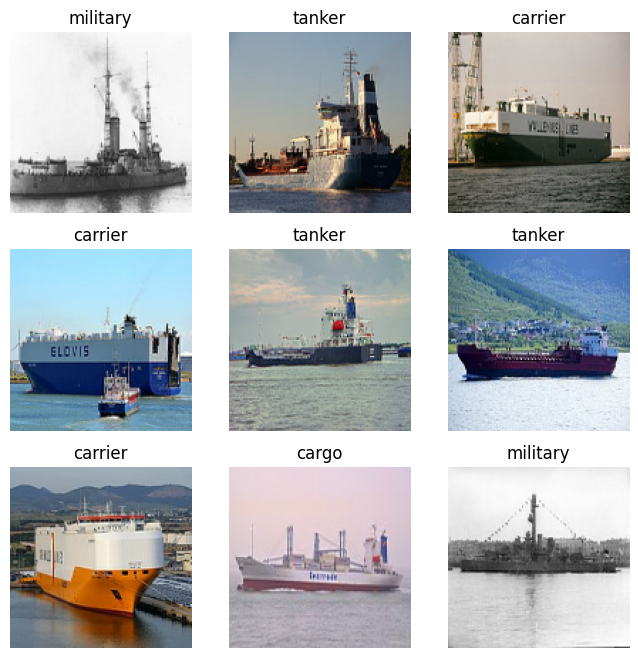

In [14]:
# Display a random set of 9 images using the Tensorflow dataset
plt.figure(figsize=(8, 8))
for images, labels in train_ds.shuffle(1000).take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(ship_category_names[int(labels[i])])
        plt.axis("off")

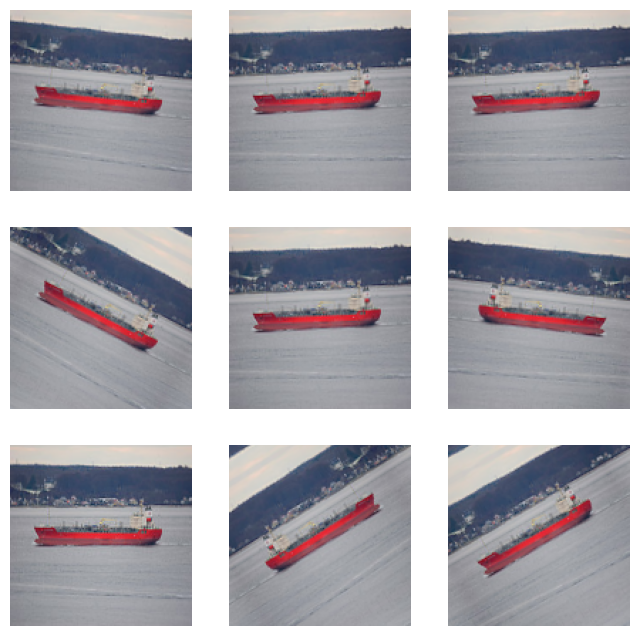

In [15]:
# Reference: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_from_scratch.ipynb
data_augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for aug_layer in data_augmentation_layers:
        images = aug_layer(images)
    return images

plt.figure(figsize=(8, 8))
for images, _ in train_ds.shuffle(500).take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [16]:
# Prepare the training and validation data by applying normalization, encoding, and augmentation
from tensorflow import data as tf_data
# Apply normalization and label encoding
train_ds = train_ds.map(lambda img, label: (img/255, tf.one_hot(label, depth = num_classes)),
                            num_parallel_calls=tf_data.AUTOTUNE)

val_ds = val_ds.map(lambda img, label: (img/255, tf.one_hot(label, depth = num_classes)),
                            num_parallel_calls=tf_data.AUTOTUNE)

# Apply `data_augmentation` only to the training images
train_ds = train_ds.map(lambda img, label: (data_augmentation(img), label),
                            num_parallel_calls=tf_data.AUTOTUNE)

# Configure the dataset for performance
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Building Models   <a id="build_model" ></a>
For this image classification task, there are six different models below including one fully-connected network, two convolutional networks (CNN), two ResNet networks, and one network that leverages MobileNet / ImageNet.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Add, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import split_dataset
from tensorflow.keras import layers, Model

In [18]:
# Fully connected network
def make_model1(input_shape, num_classes):
    model = tf.keras.models.Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation = 'sigmoid'))
    return model

In [19]:
# Three layer convolutional network with pooling and dropout
def make_model2(input_shape, num_classes):
    model = tf.keras.models.Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(16, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [20]:
# Four layer convolutional with pooling and dropout
def make_model3(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation = 'softmax'))
    return model

In [21]:
# Simple Residual Network (ResNet)
def make_model4(input_shape, num_classes):
    inputs = Input(shape=(input_shape))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Residual Block 1
    y = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    y = BatchNormalization()(y)
    y = Conv2D(64, (3, 3), activation='relu', padding='same')(y)
    y = BatchNormalization()(y)
    y = Add()([x, y])
    y = MaxPooling2D((2, 2))(y)

    # Residual Block 2
    z = Conv2D(64, (3, 3), activation='relu', padding='same')(y)
    z = BatchNormalization()(z)
    z = Conv2D(64, (3, 3), activation='relu', padding='same')(z)
    z = BatchNormalization()(z)
    z = Add()([y, z])
    z = MaxPooling2D((2, 2))(z)

    # Fully Connected Layers
    z = Flatten()(z)
    z = Dense(128, activation='relu')(z)
    z = Dropout(0.3)(z)
    outputs = Dense(num_classes, activation='sigmoid')(z)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [22]:
# Complex Residual Network model
# Reference: https://keras.io/examples/vision/image_classification_from_scratch/
def make_model5(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

In [23]:
# Use the MobileNet model provided by the Tensorflow library, using weights pre-trained on ImageNet
# Reference: https://arxiv.org/abs/1704.04861
# Reference: https://www.kaggle.com/code/shrijeethsuresh/ship-type-prediction-90-accuracy
def make_model6(input_shape, num_classes):  
    model = tf.keras.models.Sequential()
    model.add(Input(shape=input_shape))
    model.add(tf.keras.applications.MobileNet(include_top=False, weights='imagenet'))
    model.add(Conv2D(3, 3, padding='same', activation='sigmoid'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation = 'softmax'))
    return model

# Predictions on test data
The following are several functions that prepare the test data by loading a subset of the test image files, normalizing the test images, and converting them into numpy arrays.  Additionally, there are functions that help with the making predictions on the test images using the fitted models.

In [24]:
# Set up the test set images for predictions later
# Load the specified file, convert it to an array, normalize the values, and expand the
#    array dimensions to (1, imgW, imgH, 3) so it's compatible with the model.
def load_and_convert_image(filename):
    img = tf.keras.utils.load_img(filename, target_size=image_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array / 255, 0) # convert array dimensions to (1, imgSize, imgSize, 3)
    return img_array

In [25]:
# Get a sample of the test images
df_test_for_preds = df_test_from_train.sample(frac = 1)  # if frac = 1, then we'll use all test images
# Load and convert the test images to an array of arrays.  Note that the image values are normalized.
X_test = np.array(df_test_for_preds['filename'].apply(lambda x: load_and_convert_image(x)))

In [26]:
# Get predictions for each test image.  Grab the category index with the highest probability.
def get_pred_labels(model):
    y_pred_label_lists = model.predict(np.vstack(X_test))
    y_pred_labels = [lst.argmax() for lst in y_pred_label_lists]
    return y_pred_labels

In [27]:
# Utility function to display and confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_preds):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='.0f', cmap='Greens')
    plt.title("Confusion Matrix on Validation Data")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

In [28]:
# Utility function for creating the prediction labels, classification report, and confusion matrix
#   from a given trained model.
from sklearn.metrics import classification_report

def predict_and_show_CM(model, report_as_dict = False):
    y_pred_labels = get_pred_labels(model)
    # Note: df_test_for_preds['category'] are the ground truth labels for the test set
    report = classification_report(df_test_for_preds['category'], y_pred_labels, labels = range(5), 
                        target_names = ship_cat_names, digits = 3, 
                        output_dict = report_as_dict)
    if report_as_dict == False:
        print(report)
    plot_confusion_matrix(df_test_for_preds['category'], y_pred_labels)
    return report

In [29]:
# Utility function that takes a trained model and makes a prediction against a given image file
def predict_ship(model, filename, returnAll = False, display = False):
    img = tf.keras.utils.load_img(filename, target_size=image_size)
    if display:
        plt.imshow(img)

    img_array = tf.keras.utils.img_to_array(img)
    pred = model.predict(np.expand_dims(img_array / 255, 0))
    if display:
        print(pred)
    bestIdx = pred.argmax()
    # Sort the predictions in descending order
    sortedIdxs = pred.argsort()[::-1]
    if display:
        print("Best index", bestIdx)
        print("Ship predicted as:", ship_category_names[bestIdx])
    if returnAll:
        return bestIdx, sortedIdxs
    return bestIdx

# Fitting Process  <a class="anchor"  id="fitting_process"></a>
The six models above are fitted in series using the same fitting process for each.  The fitting process uses learning rate scheduling, early stopping, and model checkpoint.  
* The learning rate starts at 0.0005 and is stepped down by 30% each epoch starting at the fourth epoch.  The learning rate is prevented from going below 0.000001.
* The Early Stopping mechanism monitors the validation loss, ensuring that it continues to fall.  The process uses a patience of 5 epochs to allow the fitting process to "ring" a little bit.
* Model Checkpoint saves off the best model for use in predictions later.

Initially, the fitting process runs once for each model using the Adam optimizer and Categorical Cross-Entropy for the loss.  Three additional models are then created using the "Complex ResNet" model and fitted using the SGD and RMSprop optimizers.

In [30]:
MAX_EPOCHS = 50
patience = 5
Initial_Epochs = 3
LR = 0.0005
LR_Reduction = 0.7
Min_LR = 0.000001

checkpoint_filepath = '/kaggle/working/checkpoint.model.keras'
        
def scheduler(epoch, LR):
    if epoch <= Initial_Epochs:  # don't change anything in the first few epochs
        return LR
    if (LR * LR_Reduction) < Min_LR: # don't let the LR go below the minimum threshold
        return LR
    return (LR * LR_Reduction) # return a reduced LR

def create_fitting_callbacks():
    fitting_callbacks = [
        EarlyStopping(monitor = "val_loss", mode = 'min', patience = patience, 
                  start_from_epoch = Initial_Epochs, restore_best_weights = True, verbose = 1),
        LearningRateScheduler(scheduler),
        ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', 
                        save_best_only=True)
    ]
    return fitting_callbacks

In [31]:
# Run all of the steps for a given "make_model#" to build, compile, fit, and evaluate the model
def build_fit_model(model_builder, numEpochs):
    model = model_builder(input_shape = image_size + (3,), num_classes = num_classes)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR), 
              loss = "categorical_crossentropy", metrics=['accuracy'])
    history = model.fit(train_ds, epochs = numEpochs, 
                    callbacks = create_fitting_callbacks(), validation_data = val_ds)
    return model, history.history

In [32]:
def evaluate_predict_model(model, history, report_as_dict = False):
    epoch, val_loss, val_acc = get_best_metrics(history)
    print(f"The best epoch was #{epoch} with a loss of {round(val_loss, 3)} and accuracy of {round(val_acc, 3)}")
    plot_fitting_history(history)
    report = predict_and_show_CM(model, report_as_dict)
    return report, epoch, val_loss, val_acc

In [33]:
# Determine which epoch had the best performance based on the validation loss metric
# Once determined, return the epoch number, validation loss, and validation accuracy
# The input history is from a model fitting process
def get_best_metrics(history):
    # Fit history keys ['accuracy', 'loss', 'val_accuracy', 'val_loss'])
    minIndex = np.argmin(history["val_loss"])
    best_epoch = minIndex + 1
    best_loss = history['val_loss'][minIndex]
    best_accuracy = history['val_accuracy'][minIndex]
    return best_epoch, best_loss, best_accuracy

In [34]:
# Visualize the training process
# Accuracy history
def plot_fitting_history(history):
    acc      = history['accuracy']
    val_acc  = history['val_accuracy']
    loss     = history['loss']
    val_loss = history['val_loss']
    plt.figure(figsize = (12,4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, color = 'teal', label='Training accuracy')
    plt.plot(val_acc, color = 'orange', label = 'Validation accuracy')
    plt.title('Accuracy', fontsize=20)
    plt.xlabel('Epochs')
    plt.legend(loc = 'lower right')

    # Loss history
    plt.subplot(1, 2, 2)
    plt.plot(loss, color = 'teal', label='Training loss')
    plt.plot(val_loss, color = 'orange', label = 'Validation loss')
    plt.title('Loss', fontsize=20)
    plt.legend(loc = 'lower right')
    plt.show()

In [35]:
# Run just one model with all of the displays
MAX_EPOCHS = 15
patience = 5
Initial_Epochs = 3
LR = 0.0005

model, history = build_fit_model(make_model3, MAX_EPOCHS)

Epoch 1/15
  7/141 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2273 - loss: 1.6037 

I0000 00:00:1713112949.159491      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713112949.178741      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3309 - loss: 1.5371

W0000 00:00:1713112961.007118     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.3311 - loss: 1.5366 - val_accuracy: 0.4116 - val_loss: 1.3448 - learning_rate: 5.0000e-04
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.4454 - loss: 1.3081 - val_accuracy: 0.5280 - val_loss: 1.1273 - learning_rate: 5.0000e-04
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5226 - loss: 1.1500 - val_accuracy: 0.5582 - val_loss: 1.0210 - learning_rate: 5.0000e-04
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5648 - loss: 1.0433 - val_accuracy: 0.6018 - val_loss: 0.9493 - learning_rate: 5.0000e-04
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5936 - loss: 0.9678 - val_accuracy: 0.6053 - val_loss: 0.9373 - learning_rate: 3.5000e-04
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6221 - loss: 0.9275 - val_accuracy: 0.6258 - val_loss: 0.9120 - learning_rate: 2.4500e-04
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6

The best epoch was #7 with a loss of 0.859 and accuracy of 0.639


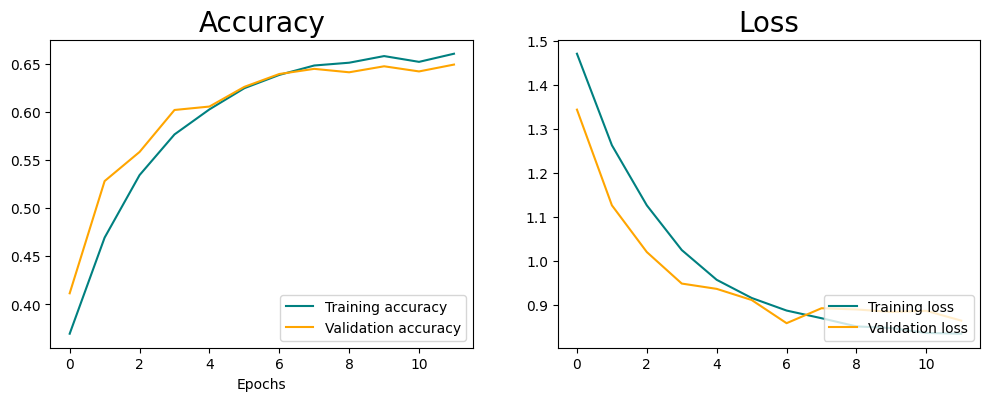

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  

W0000 00:00:1713113158.951472     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
              precision    recall  f1-score   support

       cargo      0.569     0.739     0.643       207
    military      0.707     0.611     0.655        95
     carrier      0.949     0.500     0.655       112
      cruise      0.480     0.816     0.604        87
      tanker      0.582     0.315     0.408       124

    accuracy                          0.603       625
   macro avg      0.657     0.596     0.593       625
weighted avg      0.648     0.603     0.595       625



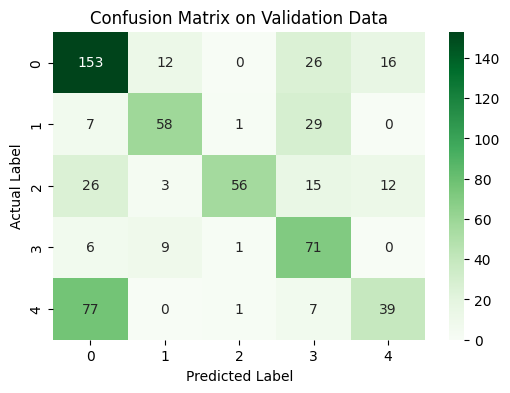

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
[[0.08557353 0.0326159  0.002428   0.86230755 0.01707494]]
Best index 3
Ship predicted as: cruise


3

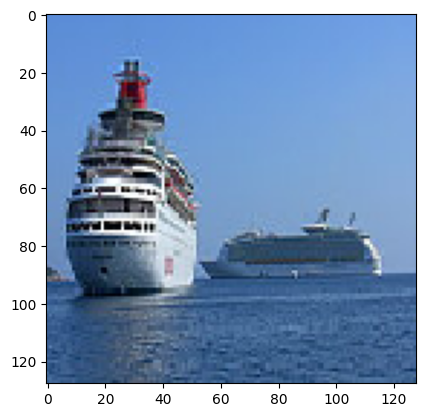

In [36]:
report, num_epochs, val_loss, val_acc = evaluate_predict_model(model, history, report_as_dict = False)
test_filename = '/kaggle/working/images/3/952227.jpg'
predict_ship(model, test_filename, display = True)

In [37]:
# Run all of the models and hyper-parameter tunings and record the results
model_results = pd.DataFrame(columns = ['Model', 'Epochs', 'Opt', 'Val Acc', 'Val Loss', 
                                        'Test Acc', 'Test Prec', 'Test Recall', 'Test F1'])

model_builders = {'Fully connected' : make_model1, 
                  '3-layer Conv'    : make_model2, 
                  '4-layer Conv'    : make_model3, 
                  'Simple ResNet'   : make_model4, 
                  'Complex ResNet'  : make_model5, 
                  'ImageNet'        : make_model6
                }

In [38]:
MAX_EPOCHS = 50
patience = 5
Initial_Epochs = 3
LR = 0.0005
fitting_histories = []
for idx, builder in enumerate(model_builders):
    print("\nFit Model:", builder, "-----------------------------------------------")
    model, history = build_fit_model(model_builders[builder], MAX_EPOCHS)
    save_model_filename = "/kaggle/working/model" + str(idx) + ".model.keras"
    shutil.copyfile(checkpoint_filepath, save_model_filename)
    fitting_histories.append(history)



Fit Model: Fully connected -----------------------------------------------
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.2604 - loss: 5.2326 - val_accuracy: 0.3449 - val_loss: 3.4598 - learning_rate: 5.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.2999 - loss: 2.2567 - val_accuracy: 0.3004 - val_loss: 1.6466 - learning_rate: 5.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.3226 - loss: 1.6942 - val_accuracy: 0.3680 - val_loss: 1.8638 - learning_rate: 5.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3315 - loss: 1.7634 - val_accuracy: 0.4000 - val_loss: 1.4117 - learning_rate: 5.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3736 - loss: 1.4985 - val_accuracy: 0.4258 - val_loss: 1.3661 - learning_rate: 3.5000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4014 - loss: 1.4273 - val_accuracy: 0.3991 - val_loss: 1.3871 - learnin

2024-04-14 16:48:34.677216: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.3048, expected 3.51669
2024-04-14 16:48:34.677273: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.67675, expected 5.88864
2024-04-14 16:48:34.677283: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.43804, expected 5.64992
2024-04-14 16:48:34.677291: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.28496, expected 4.49684
2024-04-14 16:48:34.677299: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.70669, expected 4.91857
2024-04-14 16:48:34.677307: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.97291, expected 5.18479
2024-04-14 16:48:34.677315: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.48224, expected 4.69413
2024-04-14 16:48:34.677323: E external/local_xla/xla/ser

138/141 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3206 - loss: 1.6173

2024-04-14 16:48:41.492482: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.81352, expected 3.05174
2024-04-14 16:48:41.492539: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.76775, expected 5.00597
2024-04-14 16:48:41.492556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.09548, expected 5.33371
2024-04-14 16:48:41.492570: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.38447, expected 4.6227
2024-04-14 16:48:41.492580: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.13479, expected 4.37302
2024-04-14 16:48:41.492590: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.68385, expected 3.92208
2024-04-14 16:48:41.492601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.38481, expected 3.62304
2024-04-14 16:48:41.492612: E external/local_xla/xla/ser

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3214 - loss: 1.6148

2024-04-14 16:48:49.201308: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.26053, expected 3.34476
2024-04-14 16:48:49.201369: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 7.56083, expected 6.64507
2024-04-14 16:48:49.201385: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.35016, expected 6.4344
2024-04-14 16:48:49.201396: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.65248, expected 5.73672
2024-04-14 16:48:49.201407: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.86674, expected 4.95097
2024-04-14 16:48:49.201417: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.19737, expected 5.2816
2024-04-14 16:48:49.201428: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.02832, expected 5.11255
2024-04-14 16:48:49.201438: E external/local_xla/xla/serv

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.3216 - loss: 1.6141 - val_accuracy: 0.3938 - val_loss: 1.3620 - learning_rate: 5.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.4279 - loss: 1.3291 - val_accuracy: 0.5138 - val_loss: 1.1602 - learning_rate: 5.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4960 - loss: 1.1891 - val_accuracy: 0.5378 - val_loss: 1.0963 - learning_rate: 5.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5520 - loss: 1.0907 - val_accuracy: 0.5831 - val_loss: 1.0483 - learning_rate: 5.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5684 - loss: 1.0420 - val_accuracy: 0.5893 - val_loss: 1.0781 - learning_rate: 3.5000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5899 - loss: 1.0053 - val_accuracy: 0.6000 - val_loss: 0.9948 - learning_rate: 2.4500e-04
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.

W0000 00:00:1713113419.246501     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3320 - loss: 1.5496

W0000 00:00:1713113429.628154     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.3323 - loss: 1.5491 - val_accuracy: 0.4116 - val_loss: 1.3448 - learning_rate: 5.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4202 - loss: 1.3362 - val_accuracy: 0.4898 - val_loss: 1.1813 - learning_rate: 5.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4941 - loss: 1.2015 - val_accuracy: 0.5191 - val_loss: 1.1175 - learning_rate: 5.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5445 - loss: 1.1056 - val_accuracy: 0.5431 - val_loss: 1.0504 - learning_rate: 5.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5734 - loss: 1.0155 - val_accuracy: 0.5831 - val_loss: 0.9708 - learning_rate: 3.5000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6107 - loss: 0.9518 - val_accuracy: 0.5902 - val_loss: 0.9533 - learning_rate: 2.4500e-04
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6

2024-04-14 16:53:34.992488: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.34782, expected 3.51669
2024-04-14 16:53:34.992555: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.71977, expected 5.88864
2024-04-14 16:53:34.992564: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.95696, expected 6.12583
2024-04-14 16:53:34.992572: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.48105, expected 5.64992
2024-04-14 16:53:34.992580: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.32797, expected 4.49684
2024-04-14 16:53:34.992589: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.7497, expected 4.91857
2024-04-14 16:53:34.992597: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.01592, expected 5.18479
2024-04-14 16:53:34.992605: E external/local_xla/xla/ser

139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2854 - loss: 5.0314

2024-04-14 16:53:45.246798: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.03891, expected 3.05174
2024-04-14 16:53:45.246859: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.99314, expected 5.00597
2024-04-14 16:53:45.246869: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.32087, expected 5.33371
2024-04-14 16:53:45.246877: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.60986, expected 4.6227
2024-04-14 16:53:45.246885: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.36018, expected 4.37302
2024-04-14 16:53:45.246892: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.90924, expected 3.92208
2024-04-14 16:53:45.246900: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.6102, expected 3.62304
2024-04-14 16:53:45.246908: E external/local_xla/xla/serv

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2861 - loss: 4.9959

2024-04-14 16:53:50.586521: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.25009, expected 3.34476
2024-04-14 16:53:50.586578: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 7.5504, expected 6.64507
2024-04-14 16:53:50.586588: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.33973, expected 6.4344
2024-04-14 16:53:50.586596: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.64205, expected 5.73672
2024-04-14 16:53:50.586604: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.8563, expected 4.95097
2024-04-14 16:53:50.586612: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.18693, expected 5.2816
2024-04-14 16:53:50.586620: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.01788, expected 5.11255
2024-04-14 16:53:50.586628: E external/local_xla/xla/servic

141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.2865 - loss: 4.9786 - val_accuracy: 0.2987 - val_loss: 1.5750 - learning_rate: 5.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.3668 - loss: 1.4654 - val_accuracy: 0.4142 - val_loss: 1.5006 - learning_rate: 5.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4057 - loss: 1.3941 - val_accuracy: 0.4213 - val_loss: 1.4242 - learning_rate: 5.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4215 - loss: 1.3251 - val_accuracy: 0.4338 - val_loss: 1.2901 - learning_rate: 5.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4371 - loss: 1.2709 - val_accuracy: 0.5067 - val_loss: 1.1357 - learning_rate: 3.5000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4700 - loss: 1.2035 - val_accuracy: 0.4916 - val_loss: 1.1395 - learning_rate: 2.4500e-04
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.


Fit Model: Fully connected -----------------------------------------------
The best epoch was #21 with a loss of 1.305 and accuracy of 0.469


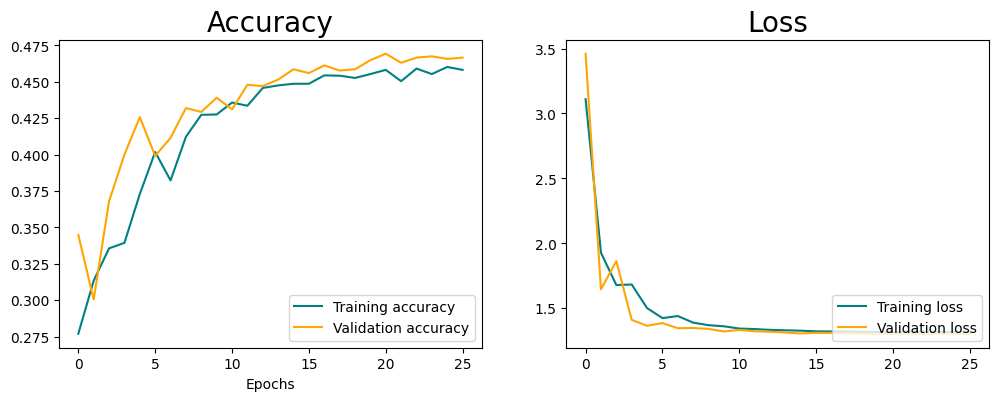

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


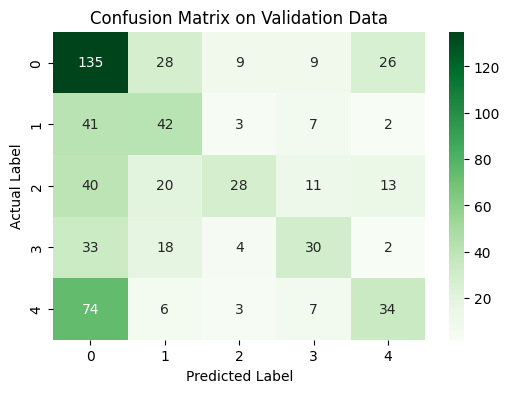


Fit Model: 3-layer Conv -----------------------------------------------
The best epoch was #12 with a loss of 0.908 and accuracy of 0.63


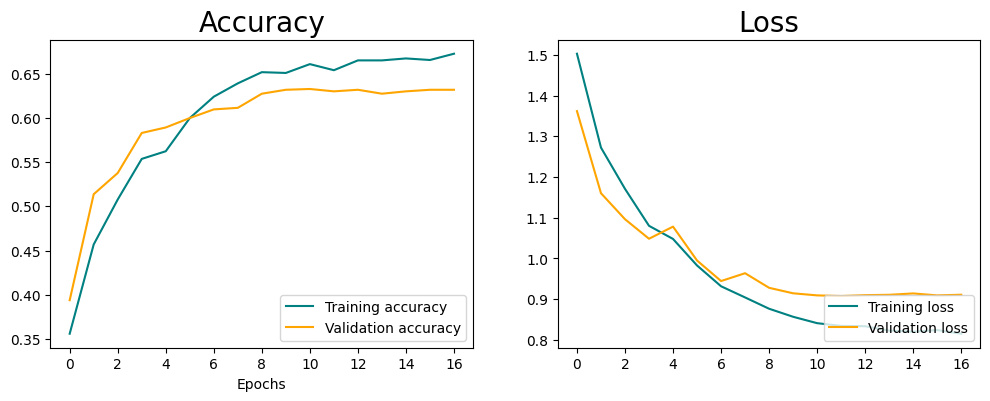

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


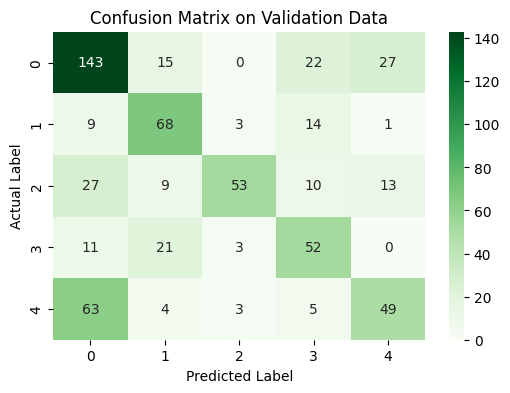


Fit Model: 4-layer Conv -----------------------------------------------
The best epoch was #33 with a loss of 0.854 and accuracy of 0.637


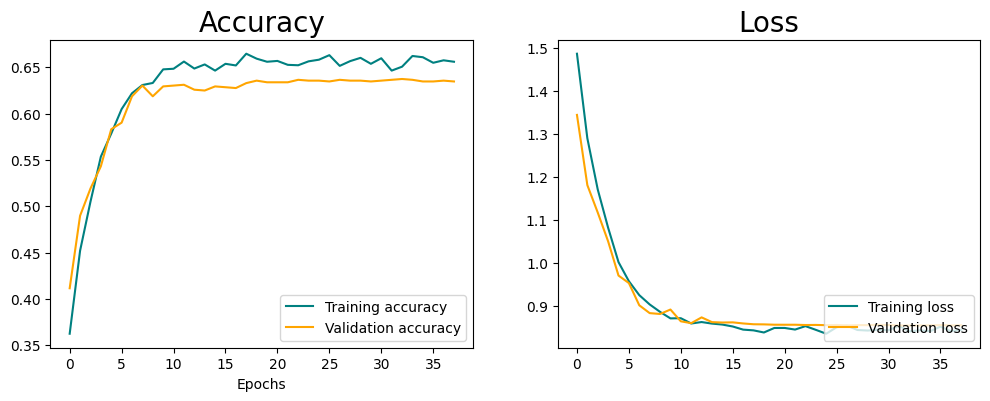

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

W0000 00:00:1713114561.186792      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


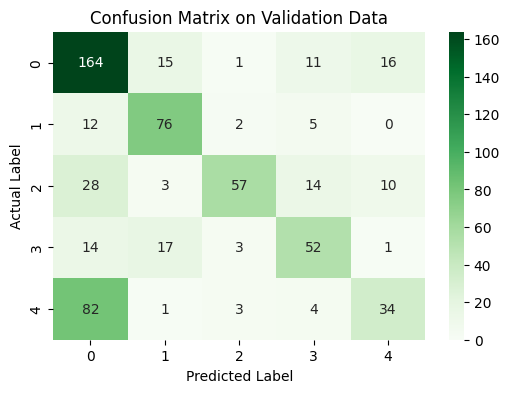


Fit Model: Simple ResNet -----------------------------------------------
The best epoch was #25 with a loss of 0.913 and accuracy of 0.601


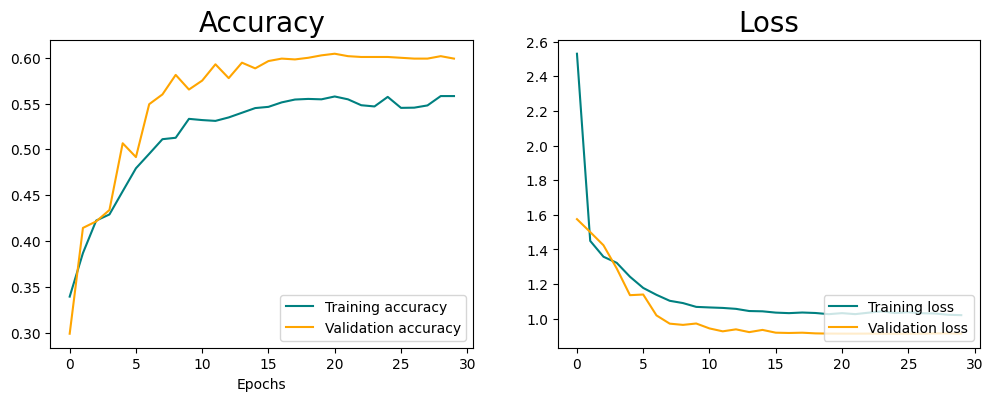

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


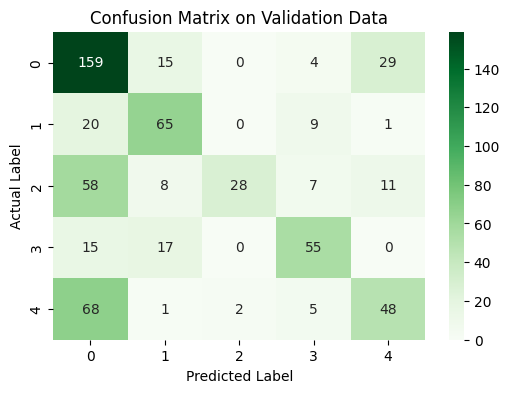


Fit Model: Complex ResNet -----------------------------------------------
The best epoch was #14 with a loss of 0.374 and accuracy of 0.855


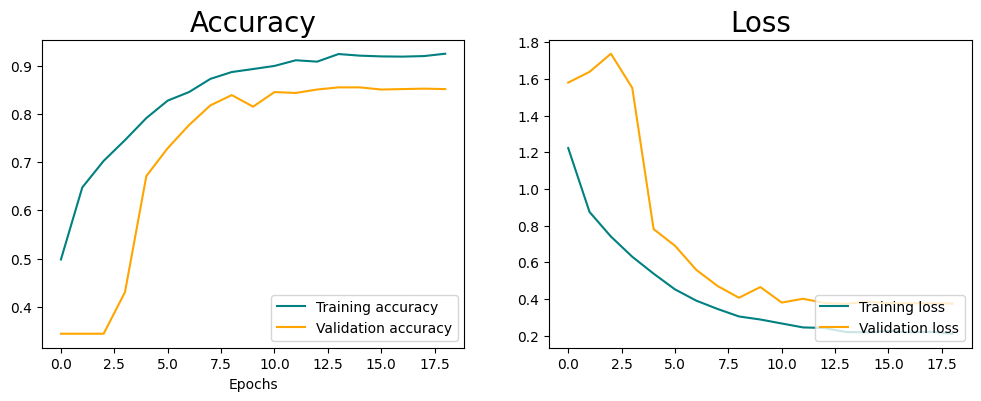

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


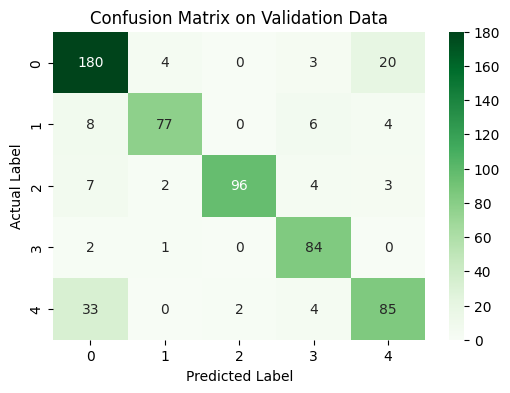

In [41]:
tf.get_logger().setLevel(3)
for idx, builder in enumerate(model_builders):
    if idx == len(model_builders) - 1: break
    print("\nFit Model:", builder, "-----------------------------------------------")
    model_filename = "/kaggle/working/model" + str(idx) + ".model.keras"
    model = tf.keras.models.load_model(model_filename)
    history = fitting_histories[idx]
    report, num_epochs, val_loss, val_acc = evaluate_predict_model(model, history, report_as_dict = True)
    model_results.at[idx, 'Model'] = list(model_builders.keys())[idx]
    model_results.at[idx, 'Epochs'] = num_epochs
    model_results.at[idx, 'Opt'] = 'Adam'
    model_results.at[idx, 'Val Acc'] = val_acc
    model_results.at[idx, 'Val Loss'] = val_loss
    model_results.at[idx, 'Test Acc'] = report['accuracy']
    model_results.at[idx, 'Test Prec'] = report['weighted avg']['precision']
    model_results.at[idx, 'Test Recall'] = report['weighted avg']['recall']
    model_results.at[idx, 'Test F1'] = report['weighted avg']['f1-score']

In [42]:
def fit_model(model, numEpochs):
    report_as_dict = True
    history = model.fit(train_ds, epochs = numEpochs, 
                        callbacks = create_fitting_callbacks(), validation_data = val_ds)
    return history

In [43]:
def record_results(model, history, idx, modelName, optName):
    report_as_dict = True
    num_epochs, val_loss, val_acc = get_best_metrics(history.history)
    print(f"The best epoch was #{num_epochs} with a loss of {round(val_loss, 3)} and accuracy of {round(val_acc, 3)}")
    plot_fitting_history(history.history)
    report = predict_and_show_CM(model, report_as_dict)
    save_model_filename = "/kaggle/working/model" + str(idx) + ".model.keras"
    shutil.copyfile(checkpoint_filepath, save_model_filename)
    model_results.at[idx, 'Model'] = modelName
    model_results.at[idx, 'Epochs'] = num_epochs
    model_results.at[idx, 'Opt'] = optName
    model_results.at[idx, 'Val Acc'] = val_acc
    model_results.at[idx, 'Val Loss'] = val_loss
    model_results.at[idx, 'Test Acc'] = report['accuracy']
    model_results.at[idx, 'Test Prec'] = report['weighted avg']['precision']
    model_results.at[idx, 'Test Recall'] = report['weighted avg']['recall']
    model_results.at[idx, 'Test F1'] = report['weighted avg']['f1-score']

In [51]:
numEpochs = 50
addOnIdx = len(model_builders)
model = make_model6(input_shape = image_size + (3,), num_classes = num_classes)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR), 
              loss = "categorical_crossentropy", metrics=['accuracy'])
history = fit_model(model, numEpochs)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.6290 - loss: 1.0014 - val_accuracy: 0.6684 - val_loss: 0.8091 - learning_rate: 5.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.8451 - loss: 0.4514 - val_accuracy: 0.8720 - val_loss: 0.4047 - learning_rate: 5.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8819 - loss: 0.3484 - val_accuracy: 0.8702 - val_loss: 0.3823 - learning_rate: 5.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8863 - loss: 0.3349 - val_accuracy: 0.8658 - val_loss: 0.3800 - learning_rate: 5.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9133 - loss: 0.2492 - val_accuracy: 0.8933 - val_loss: 0.3189 - learning_rate: 3.5000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9325 - loss: 0.2050 - val_accuracy: 0.9049 - val_loss: 0.2864 - learning_rate: 2.4500e-04
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - 

The best epoch was #16 with a loss of 0.234 and accuracy of 0.924


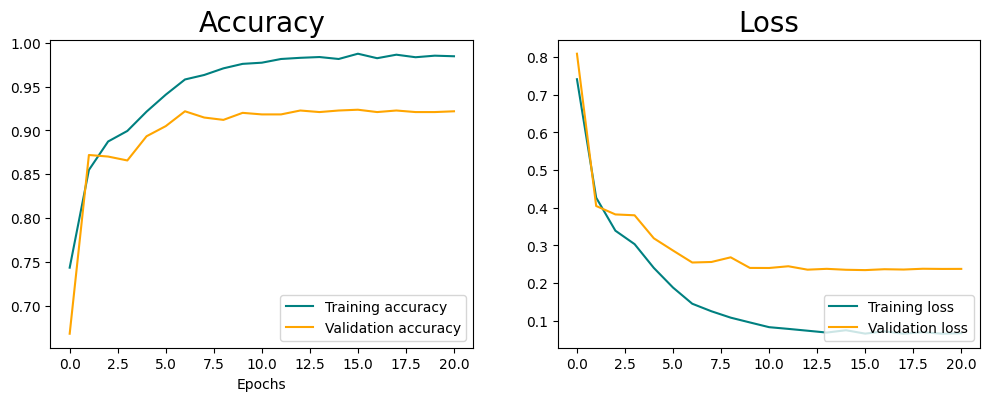

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


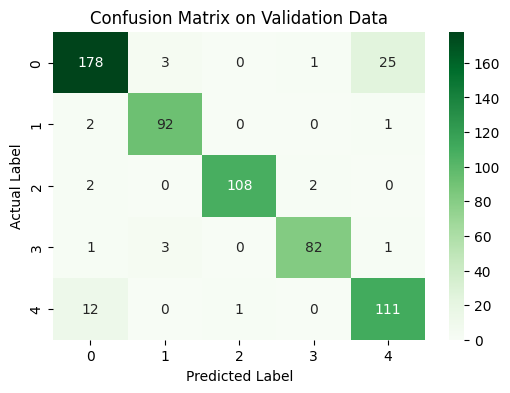

In [52]:
record_results(model, history, idx = addOnIdx-1, modelName = 'ImageNet', optName = 'Adam')

In [53]:
numEpochs = 50
addOnIdx = len(model_builders)
model = make_model5(input_shape = image_size + (3,), num_classes = num_classes)
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = LR), 
              loss = "categorical_crossentropy", metrics=['accuracy'])
history = fit_model(model, numEpochs)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.2574 - loss: 1.6118 - val_accuracy: 0.3440 - val_loss: 1.6017 - learning_rate: 5.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.3523 - loss: 1.4956 - val_accuracy: 0.3440 - val_loss: 1.5906 - learning_rate: 5.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.3744 - loss: 1.4451 - val_accuracy: 0.3440 - val_loss: 1.5741 - learning_rate: 5.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.3966 - loss: 1.4131 - val_accuracy: 0.3440 - val_loss: 1.5491 - learning_rate: 5.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.4182 - loss: 1.3802 - val_accuracy: 0.3813 - val_loss: 1.4594 - learning_rate: 3.5000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.4337 - loss: 1.3633 - val_accuracy: 0.4249 - val_loss: 1.3382 - learning_rate: 2.4500e-04
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/st

The best epoch was #47 with a loss of 1.272 and accuracy of 0.462


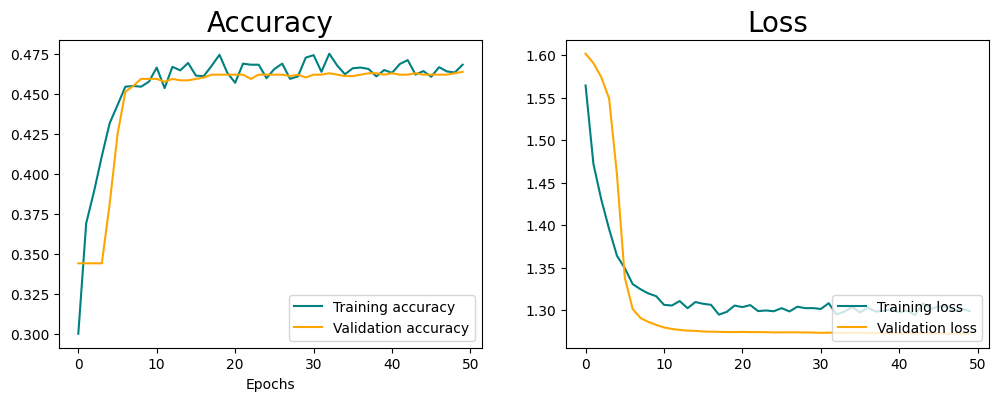

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


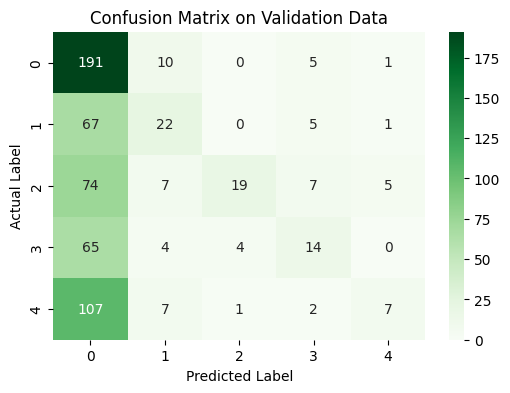

In [54]:
record_results(model, history, idx = addOnIdx, modelName = 'Complex ResNet', optName = 'SGD')

In [55]:
numEpochs = 50

model = make_model5(input_shape = image_size + (3,), num_classes = num_classes)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = LR), 
              loss = "categorical_crossentropy", metrics=['accuracy'])
history = fit_model(model, numEpochs)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 131ms/step - accuracy: 0.4256 - loss: 1.4016 - val_accuracy: 0.1636 - val_loss: 1.5875 - learning_rate: 5.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.6296 - loss: 0.9216 - val_accuracy: 0.3440 - val_loss: 1.6355 - learning_rate: 5.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.6930 - loss: 0.7626 - val_accuracy: 0.3324 - val_loss: 1.7802 - learning_rate: 5.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.7288 - loss: 0.6802 - val_accuracy: 0.3271 - val_loss: 1.6298 - learning_rate: 5.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.7750 - loss: 0.5680 - val_accuracy: 0.6782 - val_loss: 0.8250 - learning_rate: 3.5000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.8156 - loss: 0.4694 - val_accuracy: 0.7742 - val_loss: 0.5713 - learning_rate: 2.4500e-04
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/st

The best epoch was #16 with a loss of 0.406 and accuracy of 0.847


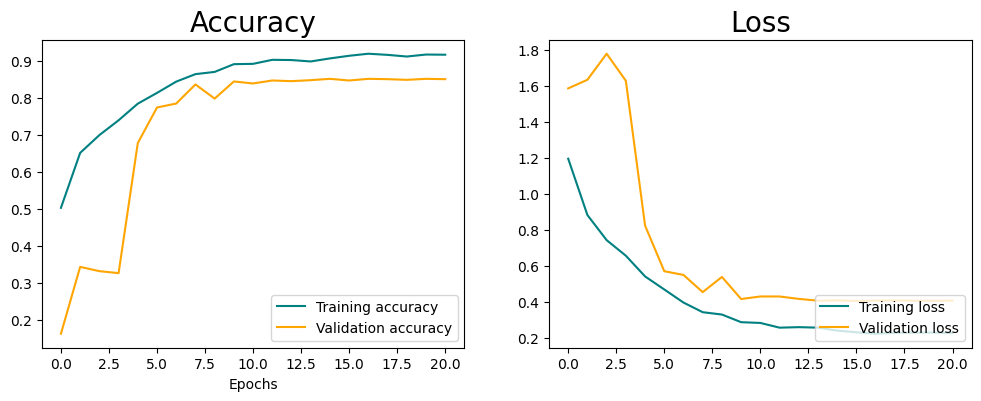

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


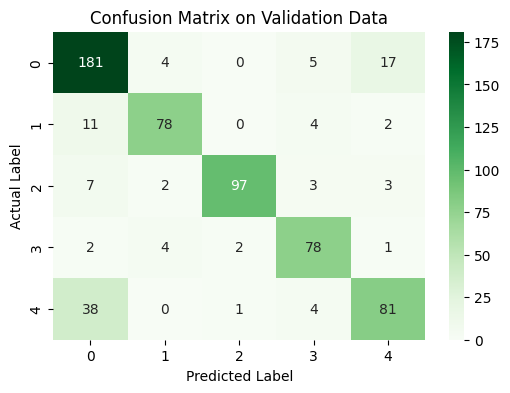

In [56]:
record_results(model, history, idx = addOnIdx+1, modelName = 'Complex ResNet', optName = 'RMSprop')

In [57]:
numEpochs = 50

model = make_model5(input_shape = image_size + (3,), num_classes = num_classes)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = LR, momentum = 0.2), 
              loss = "categorical_crossentropy", metrics=['accuracy'])
history = fit_model(model, numEpochs)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - accuracy: 0.4214 - loss: 1.4310 - val_accuracy: 0.3440 - val_loss: 1.5697 - learning_rate: 5.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.6402 - loss: 0.9176 - val_accuracy: 0.1636 - val_loss: 1.7509 - learning_rate: 5.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.6911 - loss: 0.7484 - val_accuracy: 0.1636 - val_loss: 1.9633 - learning_rate: 5.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.7229 - loss: 0.6743 - val_accuracy: 0.5902 - val_loss: 1.0938 - learning_rate: 5.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.7745 - loss: 0.5747 - val_accuracy: 0.6756 - val_loss: 0.8157 - learning_rate: 3.5000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8176 - loss: 0.4586 - val_accuracy: 0.6711 - val_loss: 1.1092 - learning_rate: 2.4500e-04
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/st

The best epoch was #13 with a loss of 0.392 and accuracy of 0.859


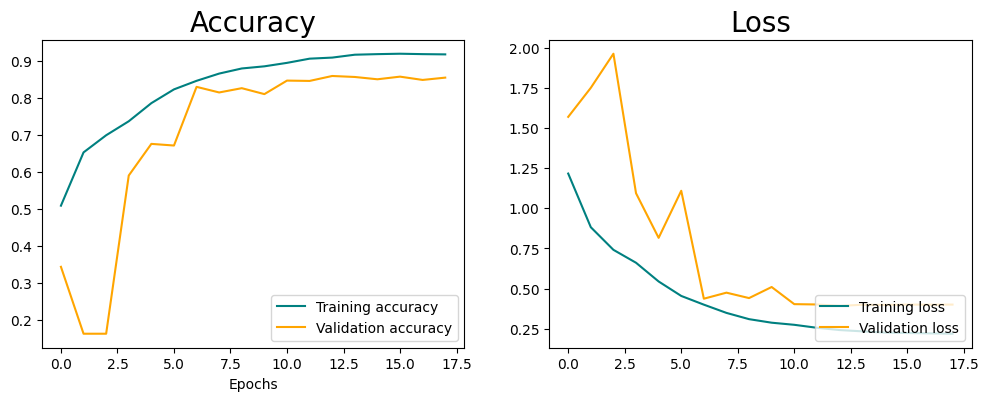

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


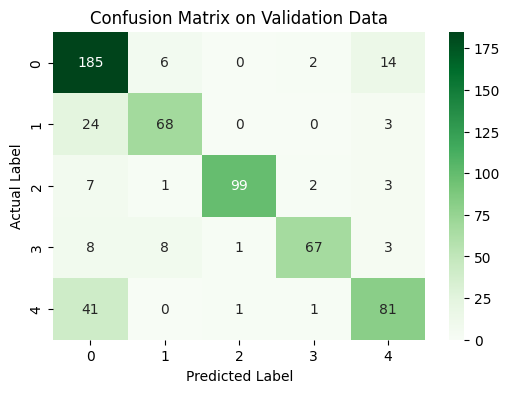

In [58]:
record_results(model, history, idx = addOnIdx+2, modelName = 'Complex ResNet', optName = 'RMSprop-Mom')

# Results and Analysis   <a class="anchor"  id="results_analysis"></a>
The following table captures the results of the fitting and prediction process.  The "Epochs" column contains the number of epochs required to achieve the model's best performance.  The "Opt" column contains the name of the optimizer that was used including Adam, SGD, and RMSprop with and without momentum.  Since the distribution of the five classes is somewhat imbalanced, the Test Accuracy is reported but not focused on.  Instead, the F1-score is focused on here as it strikes a balance between precision and recall.  

The Complex ResNet model with SGD optimizer had the worst performance with a Test F1 of 0.32.  The convolutional networks came in with a Test F1 of just under 0.60.  There was a sizeable difference between the Simple ResNet and Complex ResNet with the Complex ResNet reaching a 0.83 F1 score.

A review of the confusion matrix charts above show that many of the models had a significant issue with mis-classifying Tanker ships as Cargo ships.  Looking at the sample images, it is easy to see how those two classes could get mixed up.

In [59]:
print(tabulate(model_results.sort_index(), headers='keys', tablefmt='rounded_grid', showindex=False))

╭─────────────────┬──────────┬─────────────┬───────────┬────────────┬────────────┬─────────────┬───────────────┬───────────╮
│ Model           │   Epochs │ Opt         │   Val Acc │   Val Loss │   Test Acc │   Test Prec │   Test Recall │   Test F1 │
├─────────────────┼──────────┼─────────────┼───────────┼────────────┼────────────┼─────────────┼───────────────┼───────────┤
│ Fully connected │       21 │ Adam        │  0.469333 │   1.30496  │     0.4304 │    0.45404  │        0.4304 │  0.415362 │
├─────────────────┼──────────┼─────────────┼───────────┼────────────┼────────────┼─────────────┼───────────────┼───────────┤
│ 3-layer Conv    │       12 │ Adam        │  0.630222 │   0.907599 │     0.584  │    0.607022 │        0.584  │  0.579647 │
├─────────────────┼──────────┼─────────────┼───────────┼────────────┼────────────┼─────────────┼───────────────┼───────────┤
│ 4-layer Conv    │       33 │ Adam        │  0.637333 │   0.854431 │     0.6128 │    0.633714 │        0.6128 │  0.597256 │


# Conclusion   <a class="anchor"  id="conclusion"></a>
There was considerable variation in the performance across the many models that were built and tested.  By all metrics, the fifth model which leverages the ImageNet pre-trained weights had the best performance.  The second best performance was attained by the Complex ResNet model using the RMSprop optimizer while taking just as many epochs as the ImageNet model.

## Further work
* Much more hyper-parameter tuning could be performed using the various optimizers to see if better performance can be reached more quickly (less epochs of training).
* Since the image sizes vary a fair amount, some experimentation with image size would be interesting.  All of the training was done with an image size of 128 by 128 pixels.  However, the images are all 210 pixels by some value in the 90 to 150 range.